In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotting_helper import * 
figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

from brian2 import *
from brian2tools import *

/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
act_offset = 0
tau_Ca = 1 * ms
c_ca = 3.0
tau_w = 1 * ms

v_rest = -79
wmin = 0
wmax = 10
v_spike = -49

simple_n = '''v = I(t,i) : volt'''
poissonian = '''
    v : volt 
    v_spike : volt
    v_rest : volt
'''

poiss_threshold = 'v == v_spike'
poiss_reset = 'v = v_rest'

simple_w = '''w:1'''
simple_onpre = '''v = v_spike'''

syn_eq = '''
    ds/dt = - s/tau_s : 1 (clock-driven)
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)

    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(glutamate>0) : 1 (constant over dt)
    w_vdp = eta_vdp * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate : 1 (constant over dt)
    w_cl = eta_cl * A_p_cl  * (v - theta_p_cl)/mV * int((v - theta_p_cl)/mV > 0 ) * (vp - theta_m_cl)/mV*int((vp - theta_m_cl)/mV > 0 ) * s : 1 (constant over dt)
    w_mb = eta_mb * (A_p_mb  * (vp - theta_p_mb)/mV*int((vp - theta_p_mb)/mV > 0 ) - A_d_mb *(vm - theta_m_mb)/mV * int((vm - theta_m_mb)/mV > 0)) * s : 1 (constant over dt)



    theta_p_cl : volt
    theta_m_cl : volt
    theta_p_mb : volt
    theta_m_mb : volt
    A_p_cl : 1
    A_d_cl : 1
    A_p_mb : 1
    A_d_mb : 1
    eta_cl : 1
    eta_mb : 1
    eta_vdp : 1
    
    tau_p : second
    tau_m : second
    
    tau_s : second
    tau_glutamate : second 
    g :1
    
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  
    wmin : 1
    wmax : 1
    c_ca : 1
    tau_w : second
'''

onpre = '''
    s += g
    glutamate += Apre
    w_cl = eta_cl * A_d_cl *(vm - theta_m_cl)/mV * int((vm - theta_m_cl)/mV > 0)
    '''

def unpack_params(Syn, vdp_params, cl_params, mb_params,wmin, wmax):
    
        
    Syn.theta_p_cl = cl_params[7] * mV
    Syn.theta_m_cl = cl_params[6] * mV
    Syn.theta_p_mb = mb_params[7] * mV
    Syn.theta_m_mb = mb_params[6] * mV
    Syn.A_p_cl = cl_params[5] 
    Syn.A_d_cl = cl_params[4]
    Syn.A_p_mb = mb_params[5]
    Syn.A_d_mb = mb_params[4]
    Syn.eta_cl = cl_params[8]
    Syn.eta_mb = mb_params[8]



    
    Syn.Apre = vdp_params[0] 
    Syn.tau_glutamate = vdp_params[1] *ms
    
    Syn.k_LTD = vdp_params[2] /mV 
    LTD_rise = vdp_params[3]
    LTD_fall = vdp_params[4]
    LTP_rise = vdp_params[8]
    LTP_fall = vdp_params[9]
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = vdp_params[5] * mV
    Syn.LTD_amp = vdp_params[6]
    
    Syn.k_LTP = vdp_params[7] / mV
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = vdp_params[10] * mV
    Syn.LTP_amp = vdp_params[11]
    Syn.eta_vdp = vdp_params[12]
    Syn.wmin = wmin
    Syn.wmax = wmax
    
    Syn.tau_w = 1*ms
    Syn.tau_s = cl_params[1] * ms
    Syn.tau_p = cl_params[3] * ms
    Syn.tau_m = cl_params[2] * ms
    Syn.g = cl_params[0] 
    Syn.vp = v_rest * mV
    Syn.vm = v_rest * mV

    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))

    return Syn


def filter_prop(sim_time, n_burst, Freq_burst, Fs, vdp_params, cl_params, mb_params, rseed = 42): 
    
    start_scope()
    seed(rseed)
    
    
    
    GE = NeuronGroup(Fs.shape[0],simple_n)
    #10 repititions of the burst
    post_t = np.zeros([sim_time+int(1000/Freq_burst)*n_burst, Fs.shape[0]]) + v_rest # 1ms resolution
    #we prolong it to get no troubles with burst which extends over sim_time
    burst = np.arange(0, int(1000/Freq_burst)*n_burst, int(1000/Freq_burst))
    for i in range(Fs.shape[0]): 
        reps = np.arange(0,sim_time, int(1000/Fs[i]))
        for t in reps: 
            post_t[t+burst,i] = v_spike
    I = TimedArray(post_t * mV, dt = 1*ms)
    
    
    pre_spikes = np.arange(0,sim_time, 100) #in ms, 10Hz
    
    pre = SpikeGeneratorGroup(1, np.zeros([pre_spikes.shape[0]]), pre_spikes*ms) 

    
    Syn = Synapses(pre, GE, syn_eq, on_pre = onpre, method = 'euler')
    Syn.connect(p =1)
    Syn.w_mb = 1
    Syn.w_cl = 1
    Syn.w_vdp = 1
    Syn = unpack_params(Syn, vdp_params, cl_params, mb_params,wmin, wmax)
    
    v_mon = StateMonitor(GE, ['v'], record = True, dt = 1 * ms)
    syn_mon = StateMonitor(Syn, ['v_NMDA','VDCC', 'vp', 'vm'], record = True, dt = 1 * ms)

    
    net = Network(GE, pre, Syn,v_mon, syn_mon)

    
    net.run(sim_time*ms)
    
    return v_mon.v/mV, syn_mon.vp/mV, syn_mon.vm/mV, syn_mon.v_NMDA, syn_mon.VDCC
    
    

In [3]:
sim_time = 10000 #10s
Freqs = np.array([1,5,10,20,50])

fast_cl_params = [1/15, 15, 5,1, 12.e-3, 8.e-5,-61, -58,1]
cl_params = [1/15, 15, 10,7, 12.e-3, 8.e-5,-61, -58,1]
slow_cl_params = [1/15, 15, 15,10, 12.e-3, 8.e-5,-61, -58,1]

fast_vdp_params = [0.1, 10, 0.4, 1, 10, -40.75, 0.5, 0.4, 1,5, -40.75, 1.0, 0.1] 
vdp_params = [0.1, 10, 0.4, 1, 20, -43.75, 0.5, 0.4, 1,5, -40.75, 1.0, 0.1]
slow_vdp_params = [0.1, 10, 0.4,10,5, -40.75, 0.5, 0.4, 10,11, -40.75, 1.0, 0.1]  #doesnt mattter which way around for filter

fast_mb_params = [1/15, 15, 5,1, 6.e-3, 8e-3,-61, -58,1] 
mb_params = [1/15, 15, 10,7, 6.e-3, 8e-3,-61, -58,1] 
slow_mb_params = [1/15, 15, 15,10, 6.e-3, 8e-3,-61, -58,1] 

vs, fil_vp, fil_vm, vdp_p, vdp_m = filter_prop(sim_time, 5, 200, Freqs, fast_vdp_params, fast_cl_params, fast_mb_params)

vs, fil_vp1, fil_vm1, vdp_p1, vdp_m1 = filter_prop(sim_time, 5, 200, Freqs, slow_vdp_params, slow_cl_params, slow_mb_params)


WARNING    'c_ca' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


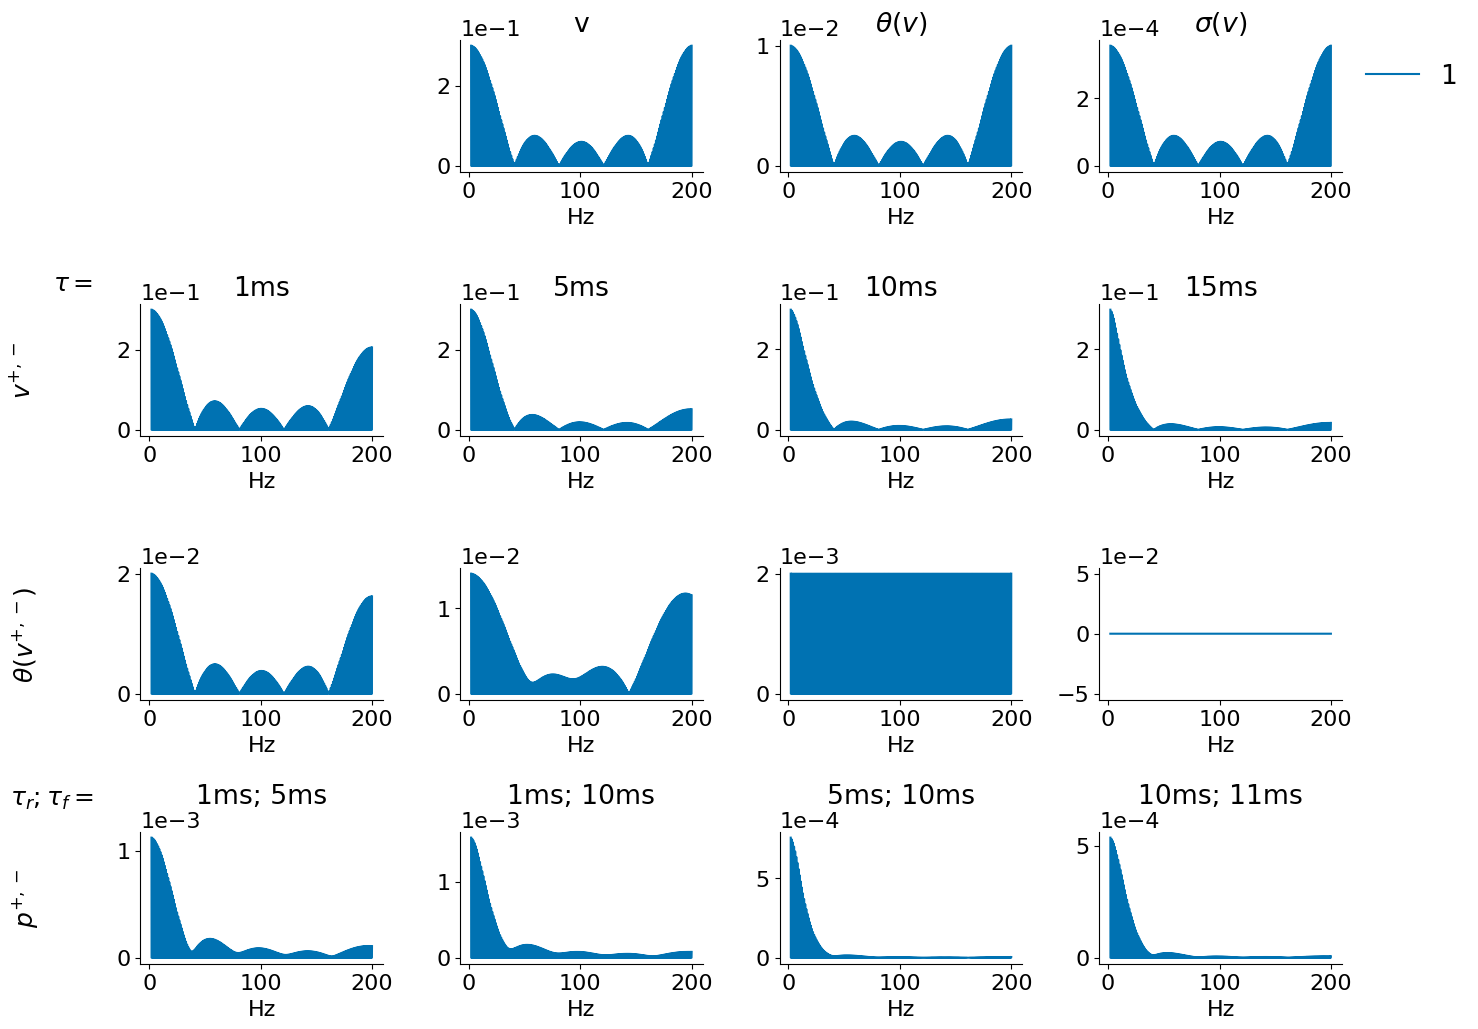

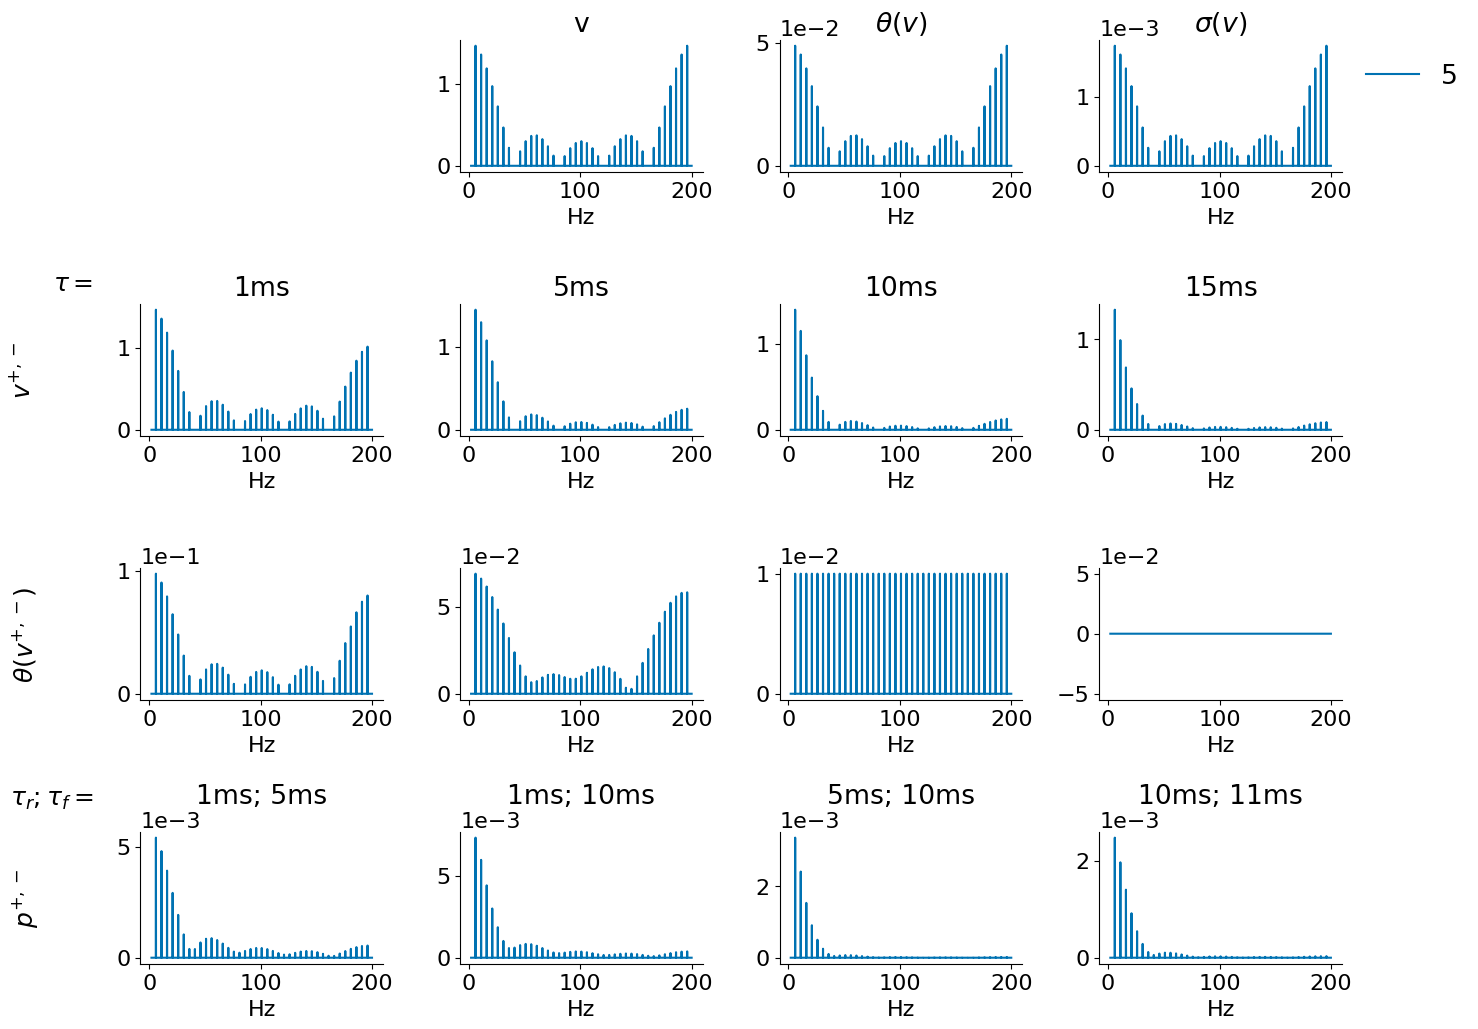

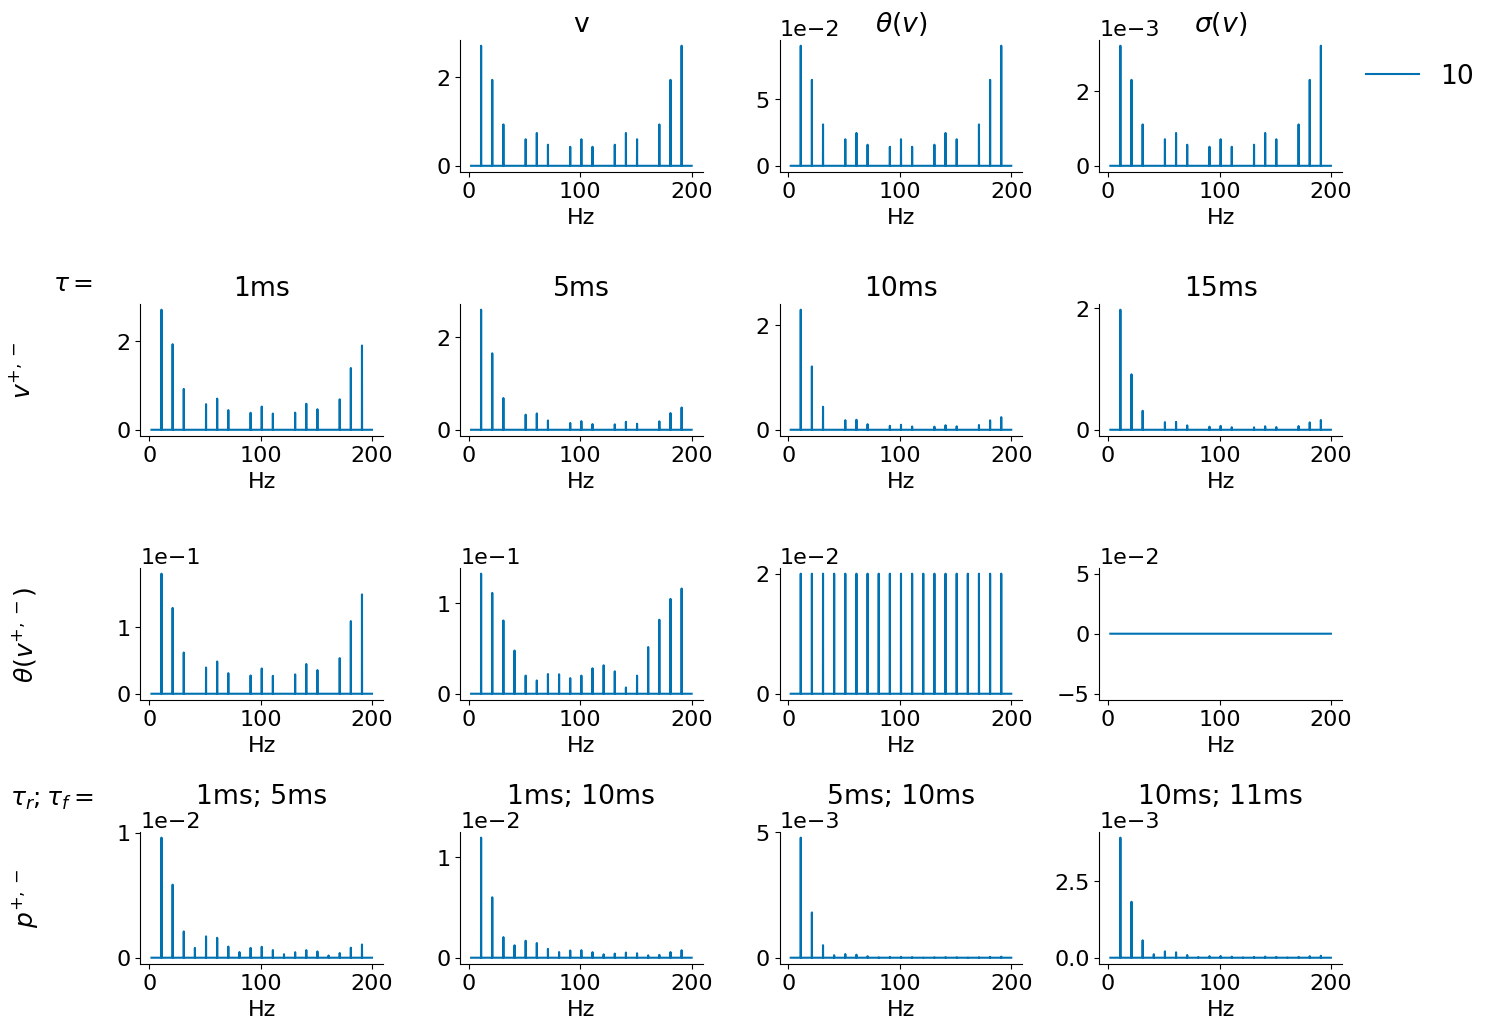

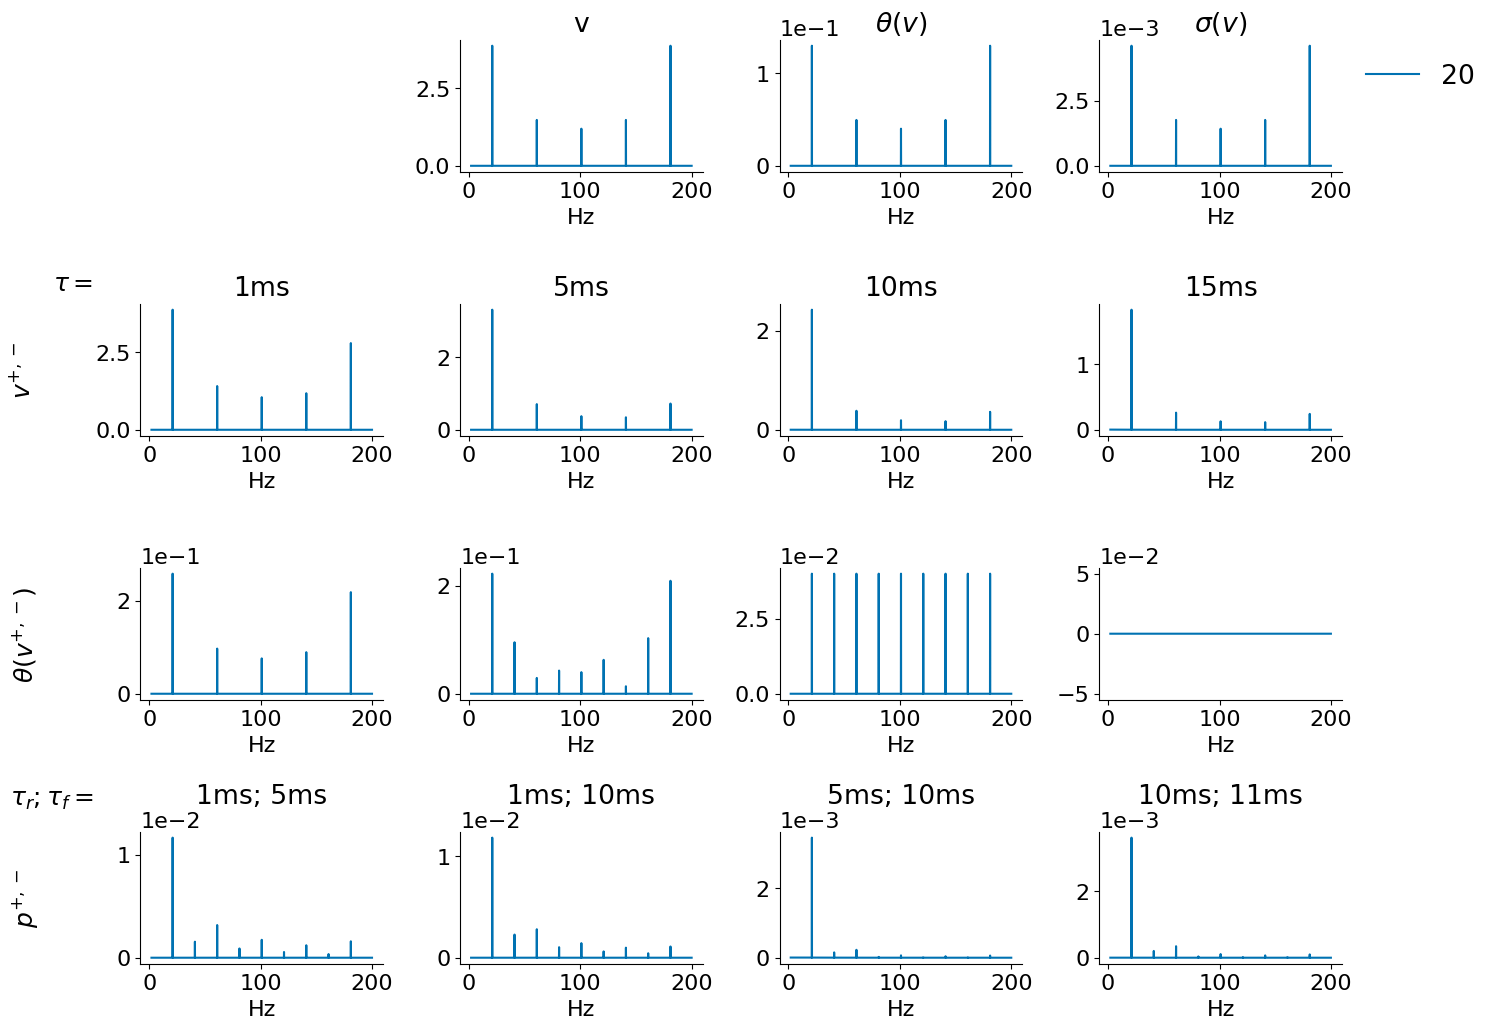

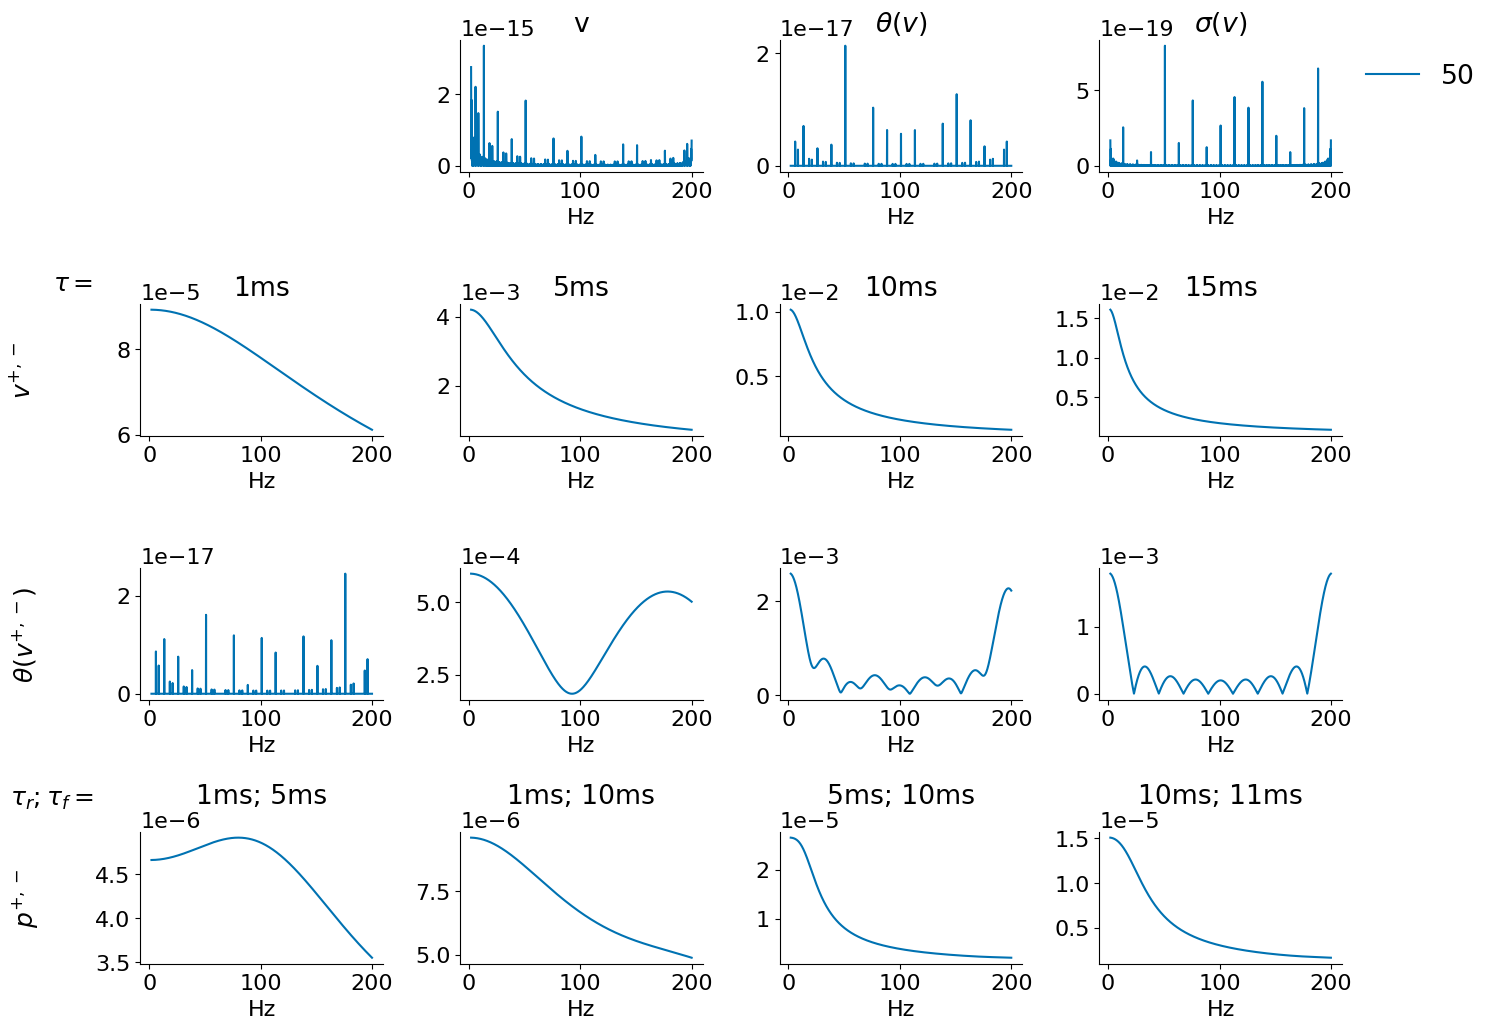

In [9]:
from scipy.fft import fft, fftfreq
#avs = np.linspace(0.2,1, Freqs.shape[0])


layout = '''
    AABBBBBB
    AABBBBBB
    CCCCCCCC
    CCCCCCCC
    CCCCCCCC
    CCCCCCCC
    DDDDDDDD
    '''
for i in range(Freqs.shape[0]): 
    fig = plt.figure(figsize=(16, 12))

    height_ratios = [1,0.05,1, 0.05,1,.05,1]
    width_ratios = [1,0.1,1, 0.1,1,.1,1,.05]

    specs, gs = panel_specs(layout, fig=fig)
    gs.set_height_ratios(height_ratios)
    gs.set_width_ratios(width_ratios)
    gs.hspace=0.8
    axes = {}
    for letter in 'ABCD':
        axes[letter] = ax = fig.add_subplot(specs[letter])
    #label_panels(axes, letters='ABC', postfix='', offset_left=1.2)
    for a in list('ABCD'):
        axes[a].set_axis_off()


    theta = -72.5
    start_plot = 10 #starts plot hat 1Hz
    freqs = fftfreq(sim_time,0.001)[start_plot:sim_time//2]
     
    plot_till = np.nonzero(freqs == 200.)[0][0]+1 #plots till 200Hz, for sure

    ax = fig.add_subplot(gs[0,2])

    fft_v = fft(vs[i])
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    ax.set_title('v')
    clear_axes(ax)
    ax.set_xlabel('Hz')
    #ax.set_ylim(-5, 150)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[0,4])

    fft_v = fft((vs[i]-theta)>0)
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),label = Freqs[i], color = palette[0])
    ax.set_title('$\\theta(v)$')
    clear_axes(ax)
    ax.set_xlabel('Hz')
    #ax.set_ylim(-0.01, 0.25)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[0,6])

    fft_v = fft(1/(1+np.exp(0.4 * (-(vs[i]--40.75)))))
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    ax.set_title('$\\sigma(v)$')
    ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
    clear_axes(ax)
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    #ax.set_ylim(-0.0001, 0.01)
    
    ax = fig.add_subplot(gs[2,0])

    fft_v = fft(fil_vp[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    ax.set_title('1ms')
    clear_axes(ax)
    ax.set_xlabel('Hz')
    #ax.set_ylim(-0.5, 10)
    ymin, ymax = ax.get_ylim()
    ax.text(-50, ymax + (ymax-ymin)/10 , '$\\tau=$', fontsize = 18, ha = 'right')
    ax.text(-125, ymin+(ymax-ymin)/2, '$v^{+,-}$', rotation = 90, fontsize = 18, va = 'center')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[4,0])
    fft_v = fft((fil_vp[i]-theta)>0)
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),  label = Freqs[i], color = palette[0])
    clear_axes(ax)
    ax.set_xlabel('Hz')
    #ax.set_ylim(-0.01, 0.3)
    ymin, ymax = ax.get_ylim()
    ax.text(-125, ymin+(ymax-ymin)/2, '$\\theta(v^{+,-})$', rotation = 90, fontsize = 18, va = 'center' )
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[2,2])
    fft_v = fft(fil_vm[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.5, 10)
    ax.set_title('5ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[4,2])

    fft_v = fft((fil_vm[i]-theta)>0)
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.01, 0.3)
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[2,4])

    fft_v = fft(fil_vp1[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.5, 10)
    ax.set_title('10ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[4,4])

    fft_v = fft((fil_vp1[i]-theta)>0)
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.01, 0.3)
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[2,6])

    fft_v = fft(fil_vm1[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),  label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.5, 10)
    ax.set_title('15ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[4,6])

    fft_v = fft((fil_vm1[i]-theta)>0)
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.01)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.01, 0.3)
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[6,0])

    fft_v = fft(vdp_p[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.001)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),  label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.001, 0.05)
    ax.set_title('1ms; 5ms')
    ymin, ymax = ax.get_ylim()
    ax.text(-50, ymax+ (ymax-ymin)/5, '$\\tau_r;\\tau_f=$', fontsize = 18, ha = 'right')
    ax.text(-125, ymin+(ymax-ymin)/2, '$p^{+,-}$', rotation = 90, fontsize = 18, va = 'center')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    ax = fig.add_subplot(gs[6,2])

    fft_v = fft(vdp_m[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.001)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]),  label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.001, 0.05)
    ax.set_title('1ms; 10ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    ax = fig.add_subplot(gs[6,4])

    fft_v = fft(vdp_p1[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.001)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.001, 0.05)
    ax.set_title('5ms; 10ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    ax = fig.add_subplot(gs[6,6])

    fft_v = fft(vdp_m1[i])
    #to_plot = np.nonzero((2.0/sim_time * np.abs(fft_v[0:sim_time//2]))>0.001)[0]
    ax.plot(freqs[start_plot:plot_till], 2.0/sim_time * np.abs(fft_v[start_plot:plot_till]), label = Freqs[i], color = palette[0])
    clear_axes(ax)
    #ax.set_ylim(-0.001, 0.05)
    ax.set_title('10ms; 11ms')
    ax.set_xlabel('Hz')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.savefig(figures_path+'appfig_filter'+str(Freqs[i])+'.pdf', bbox_inches='tight')

    plt.show()
    
